# Model V4 Active Cases

v4

In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor


%matplotlib inline

1.00000000016935, mean is 23.85639871290625


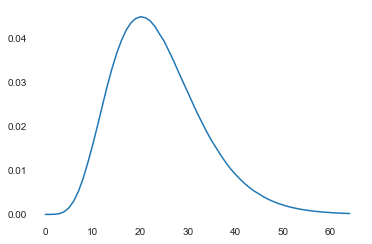

In [89]:
DelayProb = np.array(
            [
                0,
                2.10204045e-06,
                3.22312869e-05,
                1.84979560e-04,
                6.31412913e-04,
                1.53949439e-03,
                3.07378372e-03,
                5.32847235e-03,
                8.32057678e-03,
                1.19864352e-02,
                1.59626950e-02,
                2.02752812e-02,
                2.47013776e-02,
                2.90892369e-02,
                3.30827134e-02,
                3.66035310e-02,
                3.95327745e-02,
                4.19039762e-02,
                4.35677913e-02,
                4.45407357e-02,
                4.49607434e-02,
                4.47581467e-02,
                4.40800885e-02,
                4.28367817e-02,
                4.10649618e-02,
                3.93901360e-02,
                3.71499615e-02,
                3.48922699e-02,
                3.24149652e-02,
                3.00269472e-02,
                2.76836725e-02,
                2.52794388e-02,
                2.29349630e-02,
                2.07959867e-02,
                1.86809336e-02,
                1.67279378e-02,
                1.50166767e-02,
                1.33057159e-02,
                1.17490048e-02,
                1.03030011e-02,
                9.10633952e-03,
                7.97333972e-03,
                6.95565185e-03,
                6.05717970e-03,
                5.25950540e-03,
                4.61137626e-03,
                3.94442886e-03,
                3.37948046e-03,
                2.91402865e-03,
                2.48911619e-03,
                2.14007737e-03,
                1.81005702e-03,
                1.54339818e-03,
                1.32068199e-03,
                1.11358095e-03,
                9.53425490e-04,
                7.99876440e-04,
                6.76156345e-04,
                5.68752088e-04,
                4.93278826e-04,
                4.08596625e-04,
                3.37127249e-04,
                2.92283720e-04,
                2.41934846e-04,
                1.98392580e-04,
            ]
        )

plt.plot(DelayProb)
print(f"{np.sum(DelayProb)}, mean is {np.sum([i * DelayProb[i] for i in range(len(DelayProb))])}")

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   ... mean  ... max   ... unique
 1 Healthcare specialisation                  0.000 ... 0.055 ... 1.000 ... [0. 1.]
 2 Mask wearing over 70%                      0.000 ... 0.061 ... 1.000 ... [0. 1.]
 3 Gatherings limited to 1000                 0.000 ... 0.258 ... 1.000 ... [0. 1.]
 4 Gatherings limited to 100                  0.000 ... 0.241 ... 1.000 ... [0. 1.]
 5 Gatherings limited to 10                   0.000 ... 0.165 ... 1.000 ... [0. 1.]
 6 Business suspended - some                  0.000 ... 0.322 ... 1.000 ... [0. 1.]
 7 Business suspended - many                  0.000 ... 0.269 ... 1.000 ... [0. 1.]
 8 Schools and universities closed            0.000 ... 0.331 ... 1.

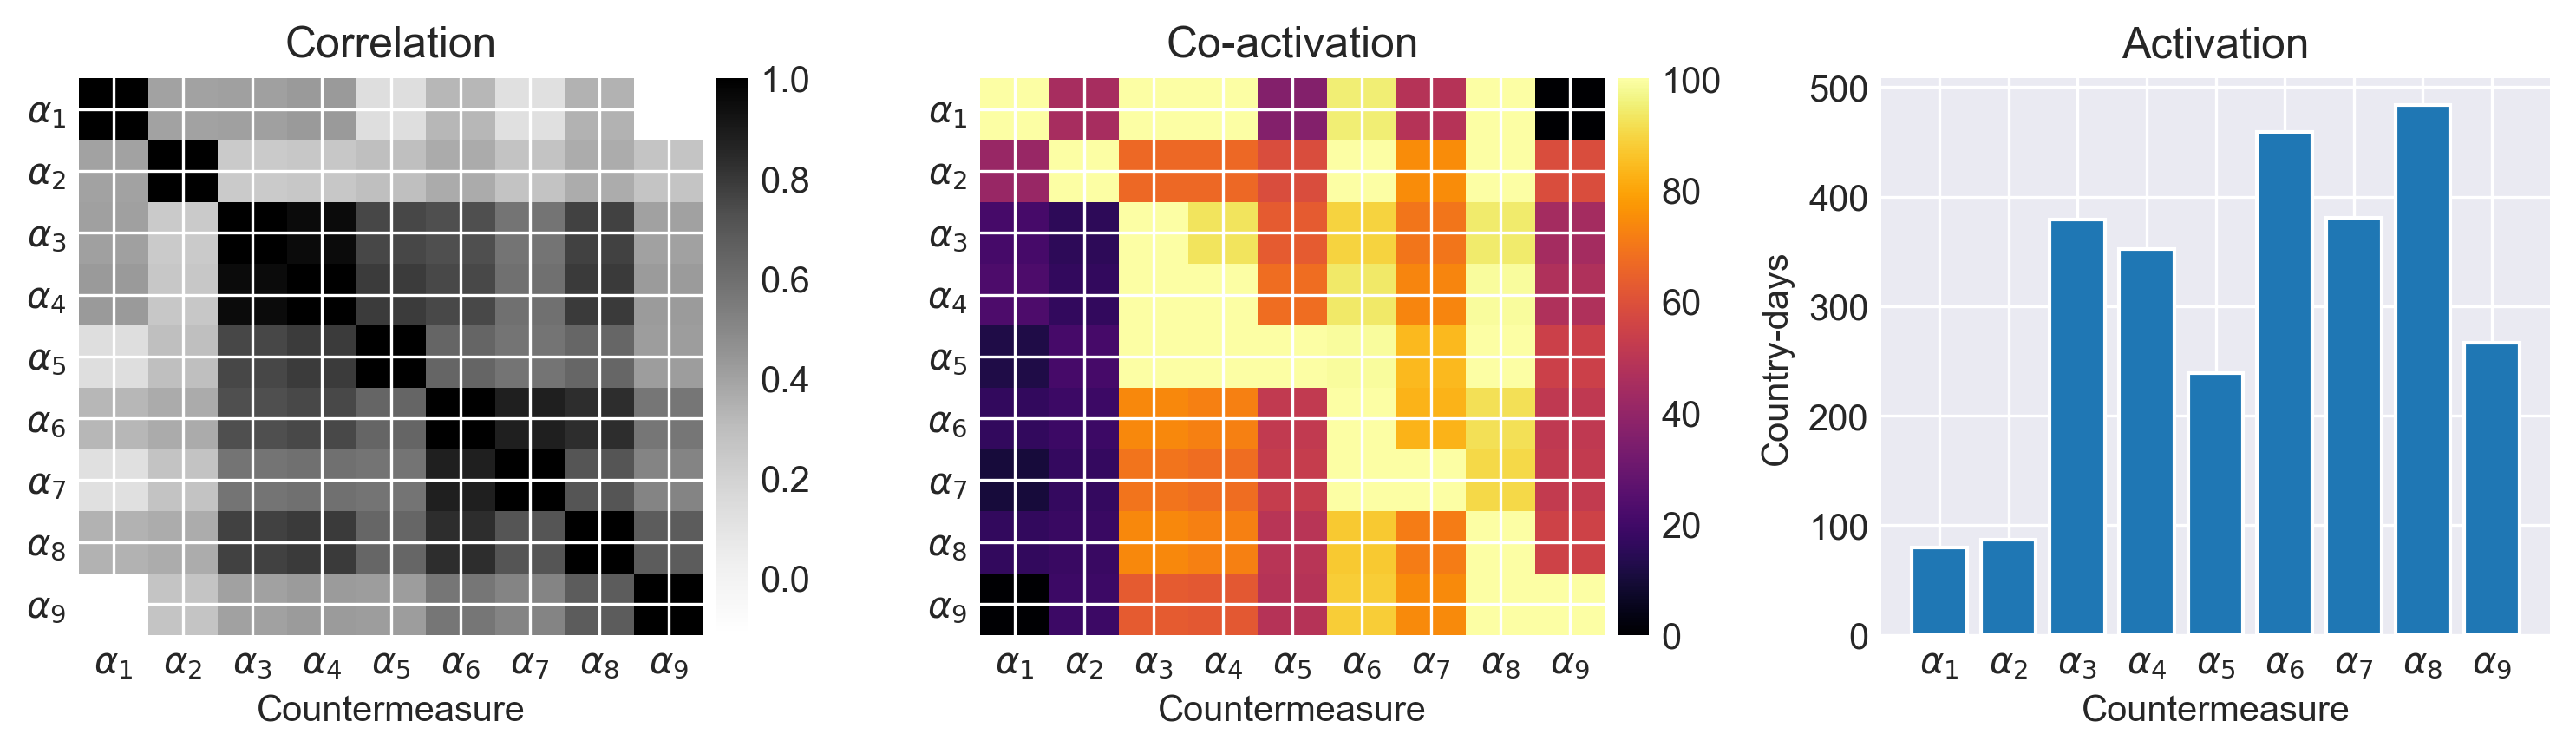

In [81]:
regions = ['AT', 'BE', 'CH', 'CZ', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR','HU', 'IE', 'IT', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE']
# Same, outside Europe
regions += ['CN-HK', 'EG', 'IL', 'JP', 'KR', 'MX', 'MY', 'MA']
regions = regions[:12]

features = ['Healthcare specialisation', 
             'Mask wearing over 70%',
 'Gatherings limited to 1000',    
 'Gatherings limited to 100',
 'Gatherings limited to 10',
 'Business suspended - some',
 'Business suspended - many',
 'Schools and universities closed',
 'General curfew'
 ]

dp = DataPreprocessor(end_date="2020-04-21")
data = dp.preprocess_data("../../data", regions, features, selected_cm_set="countermeasures-model-boolean_Gat3Bus2SchCurHespMa.csv")

def mask_region(d, region, start):
    heldout = d.Rs.index(region)
    d.Active.mask[heldout,start:] = True
    d.Confirmed.mask[heldout,start:] = True
    d.Deaths.mask[heldout,start:] = True
    d.NewDeaths.mask[heldout,start:] = True

mask_region(data, 'AT', 32)
mask_region(data, 'BE', 40)
mask_region(data, 'CH', 40)

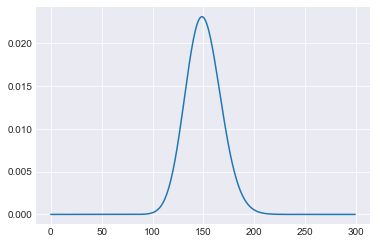

In [82]:
d1 = pm.NegativeBinomial.dist(mu = 150, alpha = 150)
vals = np.exp(d1.logp(np.arange(300)).eval())
plt.plot(vals)

In [83]:
with cm_effect.models.CMDeathModelFlexibleV2(data) as model:
    model.DailyGrowthNoise=0.15
    model.build_cm_reduction_exp_gamma_prior()
    model.build_region_growth_prior()
    model.build_region_reliability_prior()
    model.build_rates()
    model.build_output_model()

/Users/jsalvatier/Library/Caches/pypoetry/virtualenvs/epimodel-Y5DpXmSQ-py3.8/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [84]:
with model:
    model.trace = pm.sample(500, cores=2, init="adapt_diag")

Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [InitialSize_log, Growth, Phi, RegionGrowthRate_log, CM_Alpha]
INFO:pymc3:>NUTS: [InitialSize_log, Growth, Phi, RegionGrowthRate_log, CM_Alpha]
>Metropolis: [Observed_missing]
INFO:pymc3:>Metropolis: [Observed_missing]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [08:45<00:00,  3.81draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/heldout_validation/out


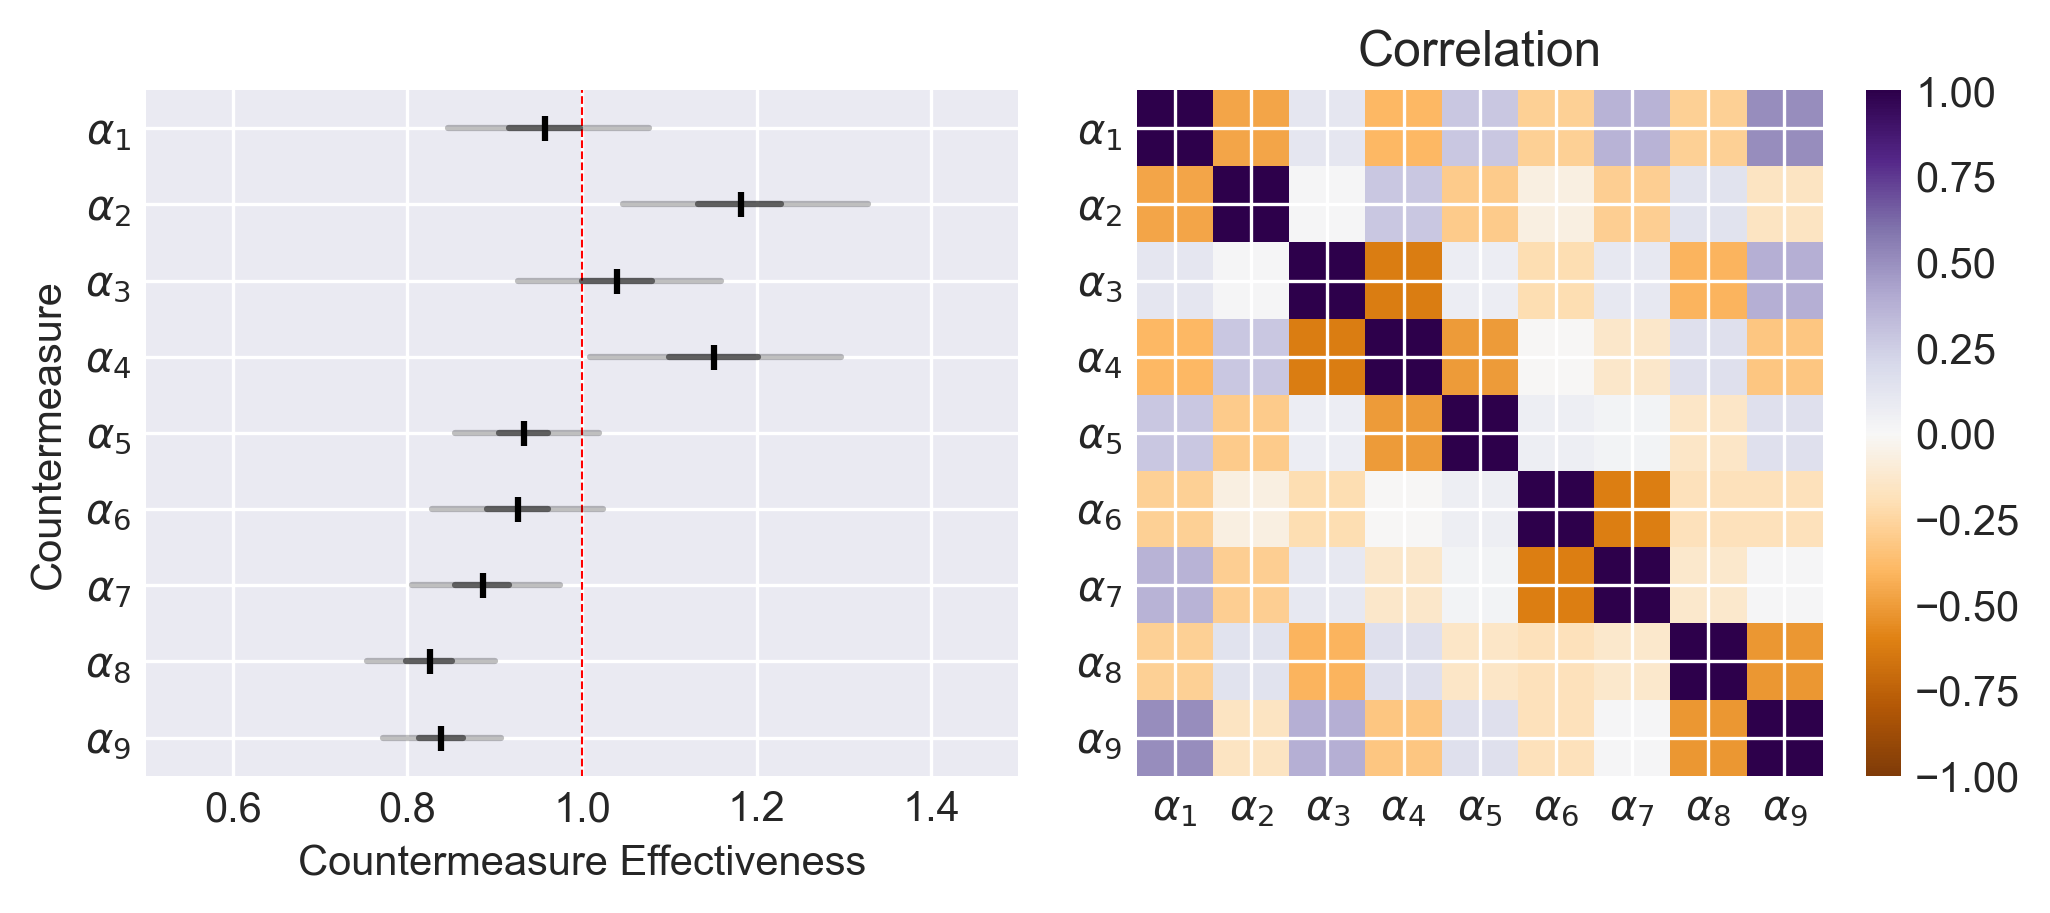

In [85]:
model.plot_effect()

INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/heldout_validation/out
INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/jsalvatier/workspace/cov19/epimodel/notebooks/heldout_validation/out


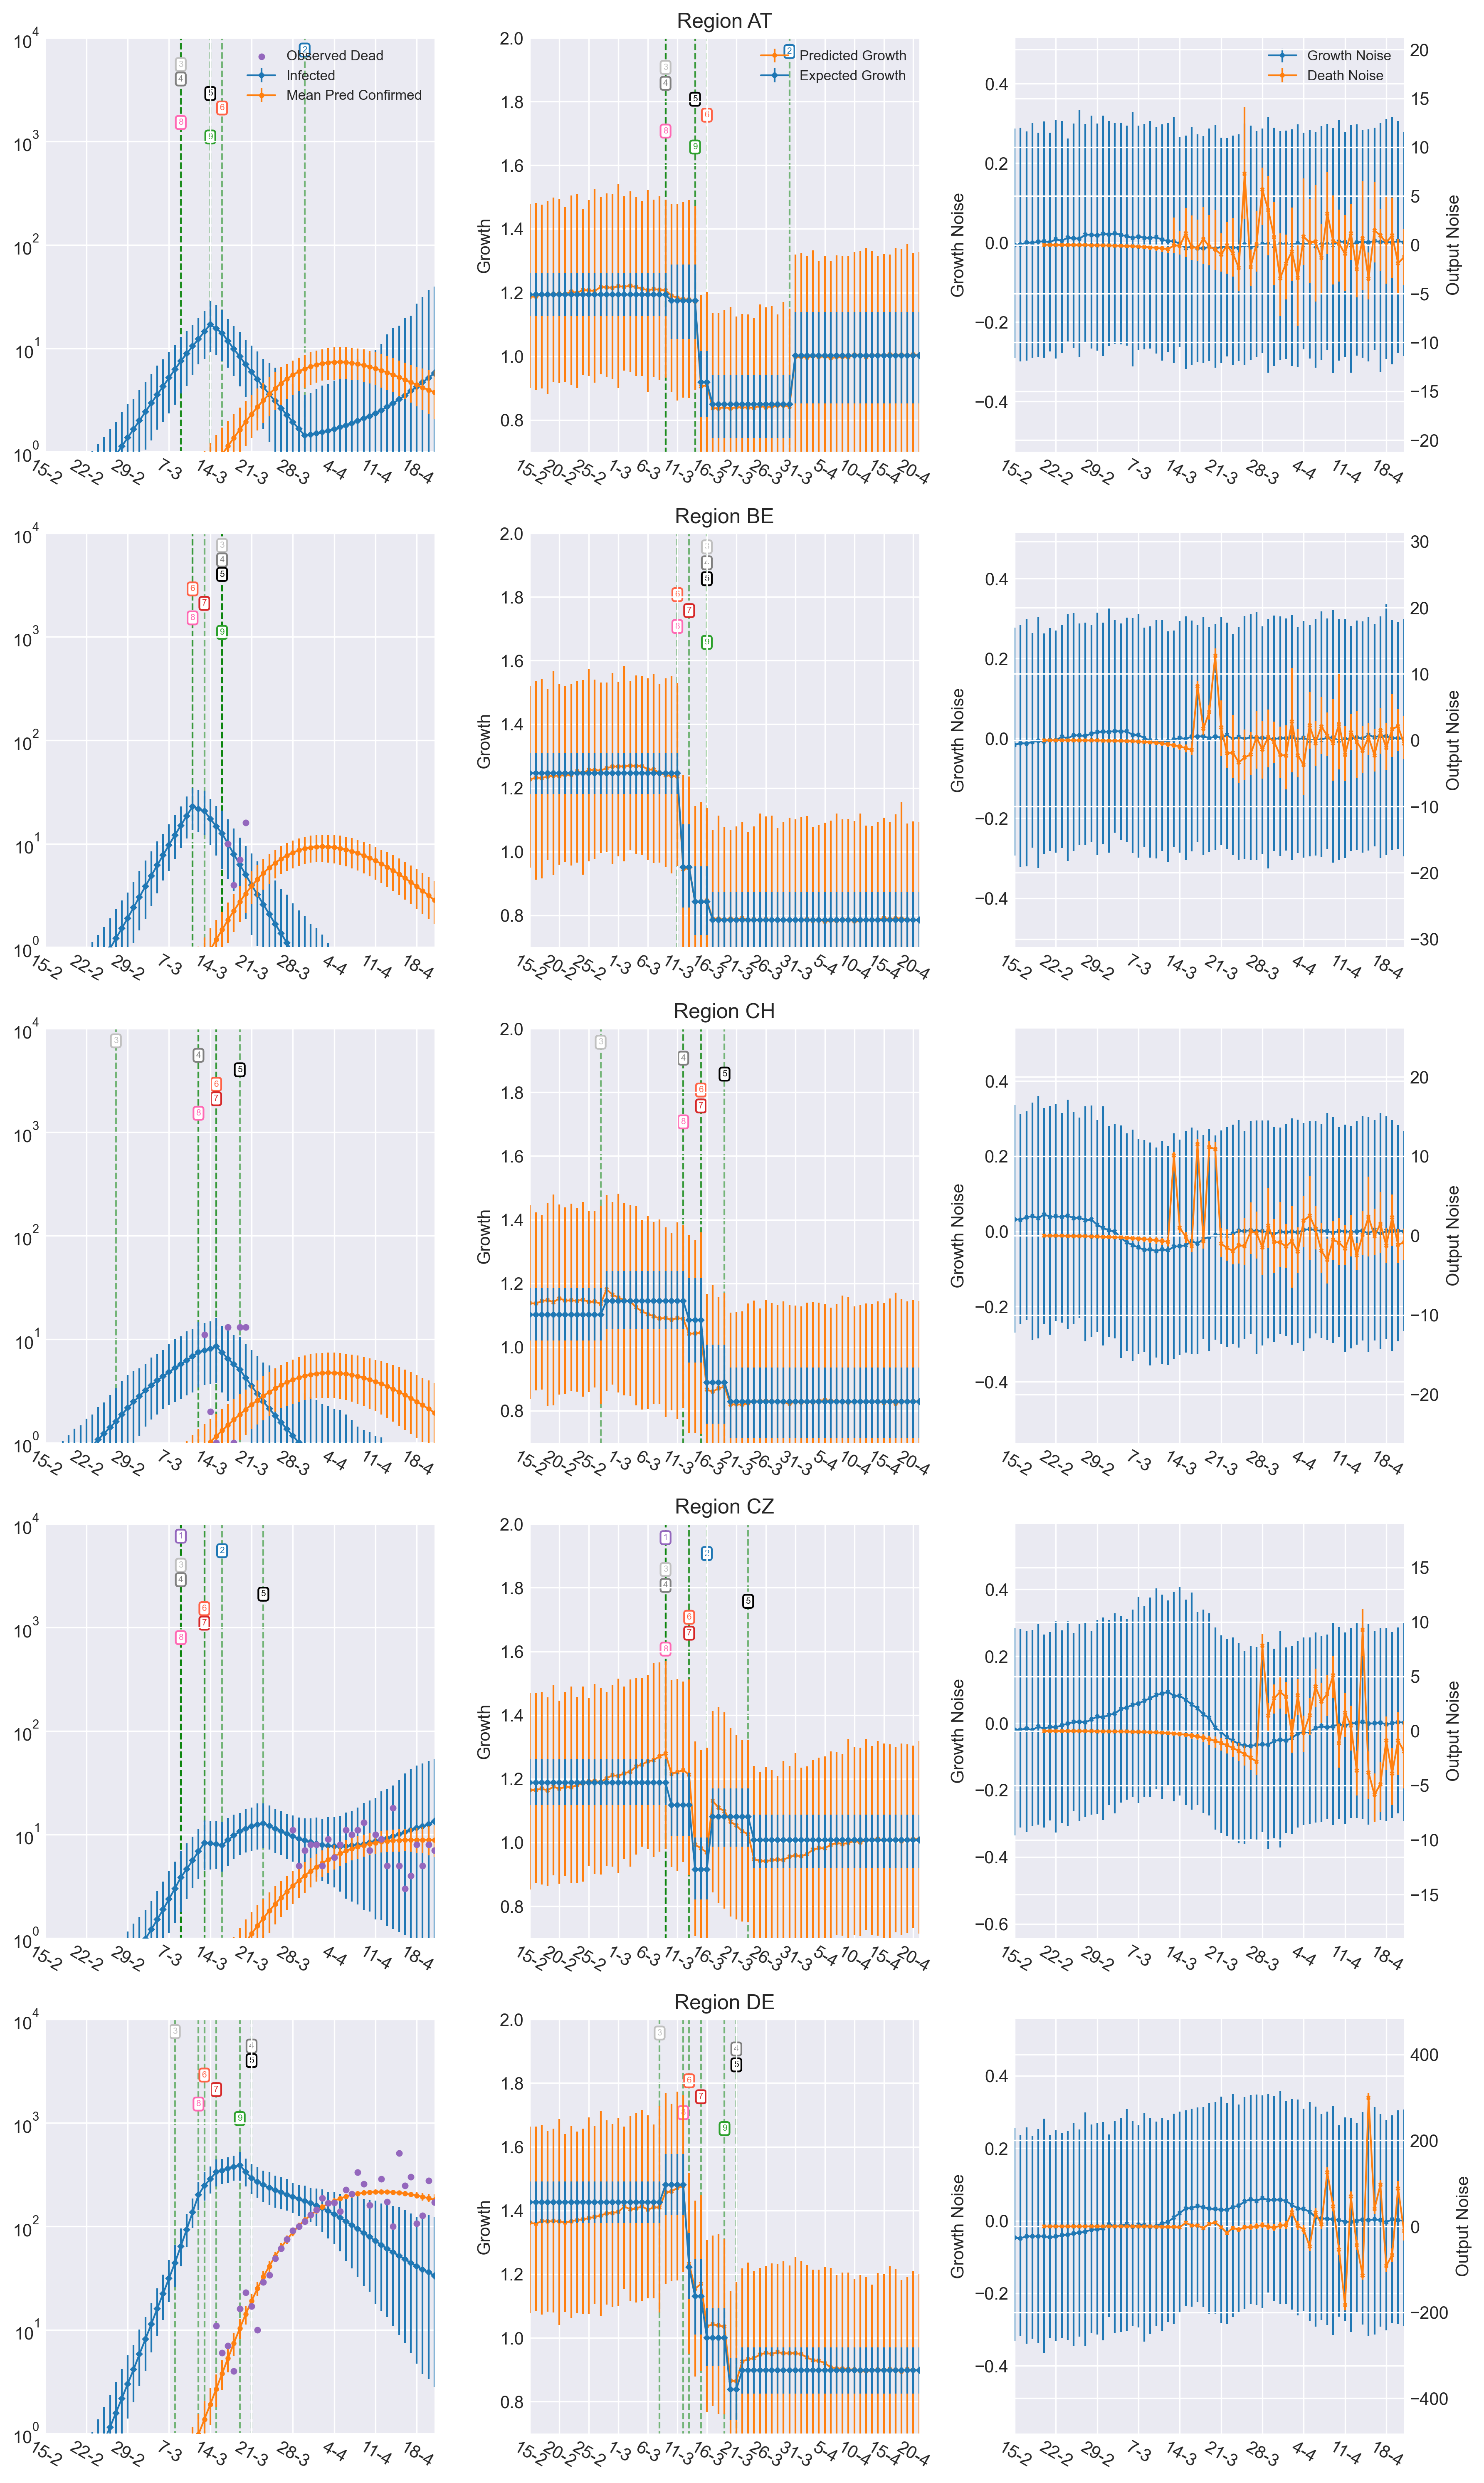

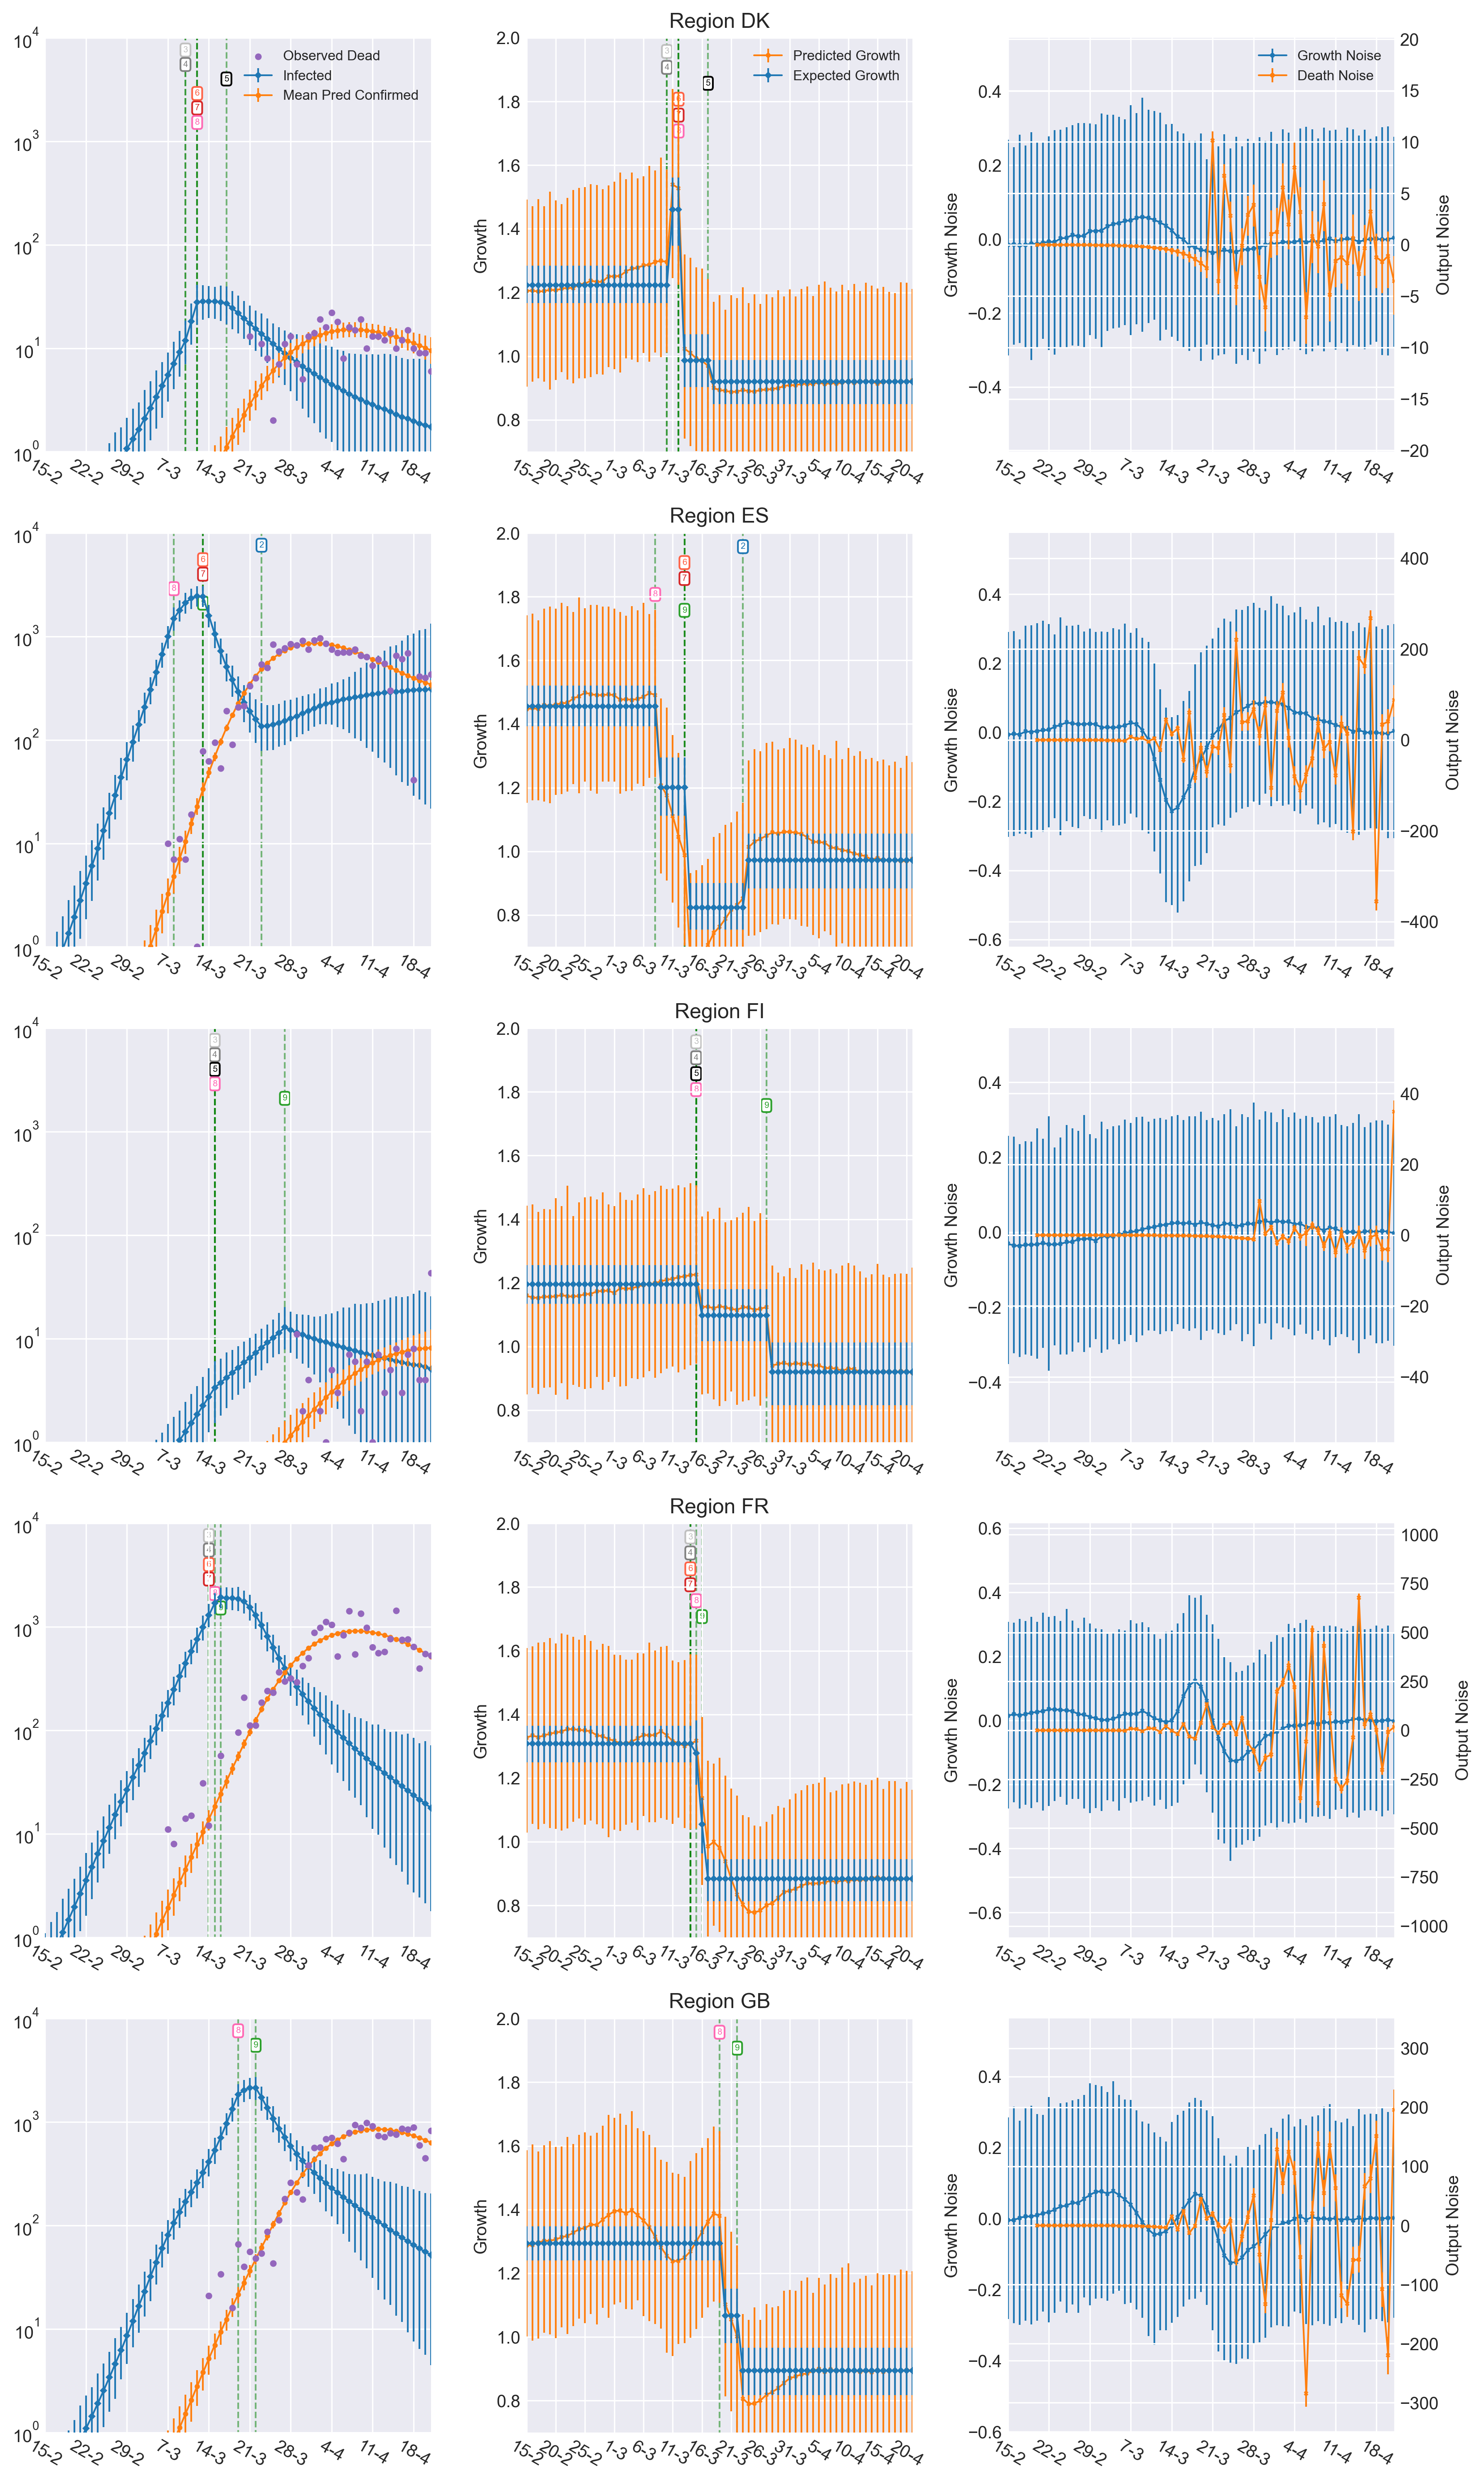

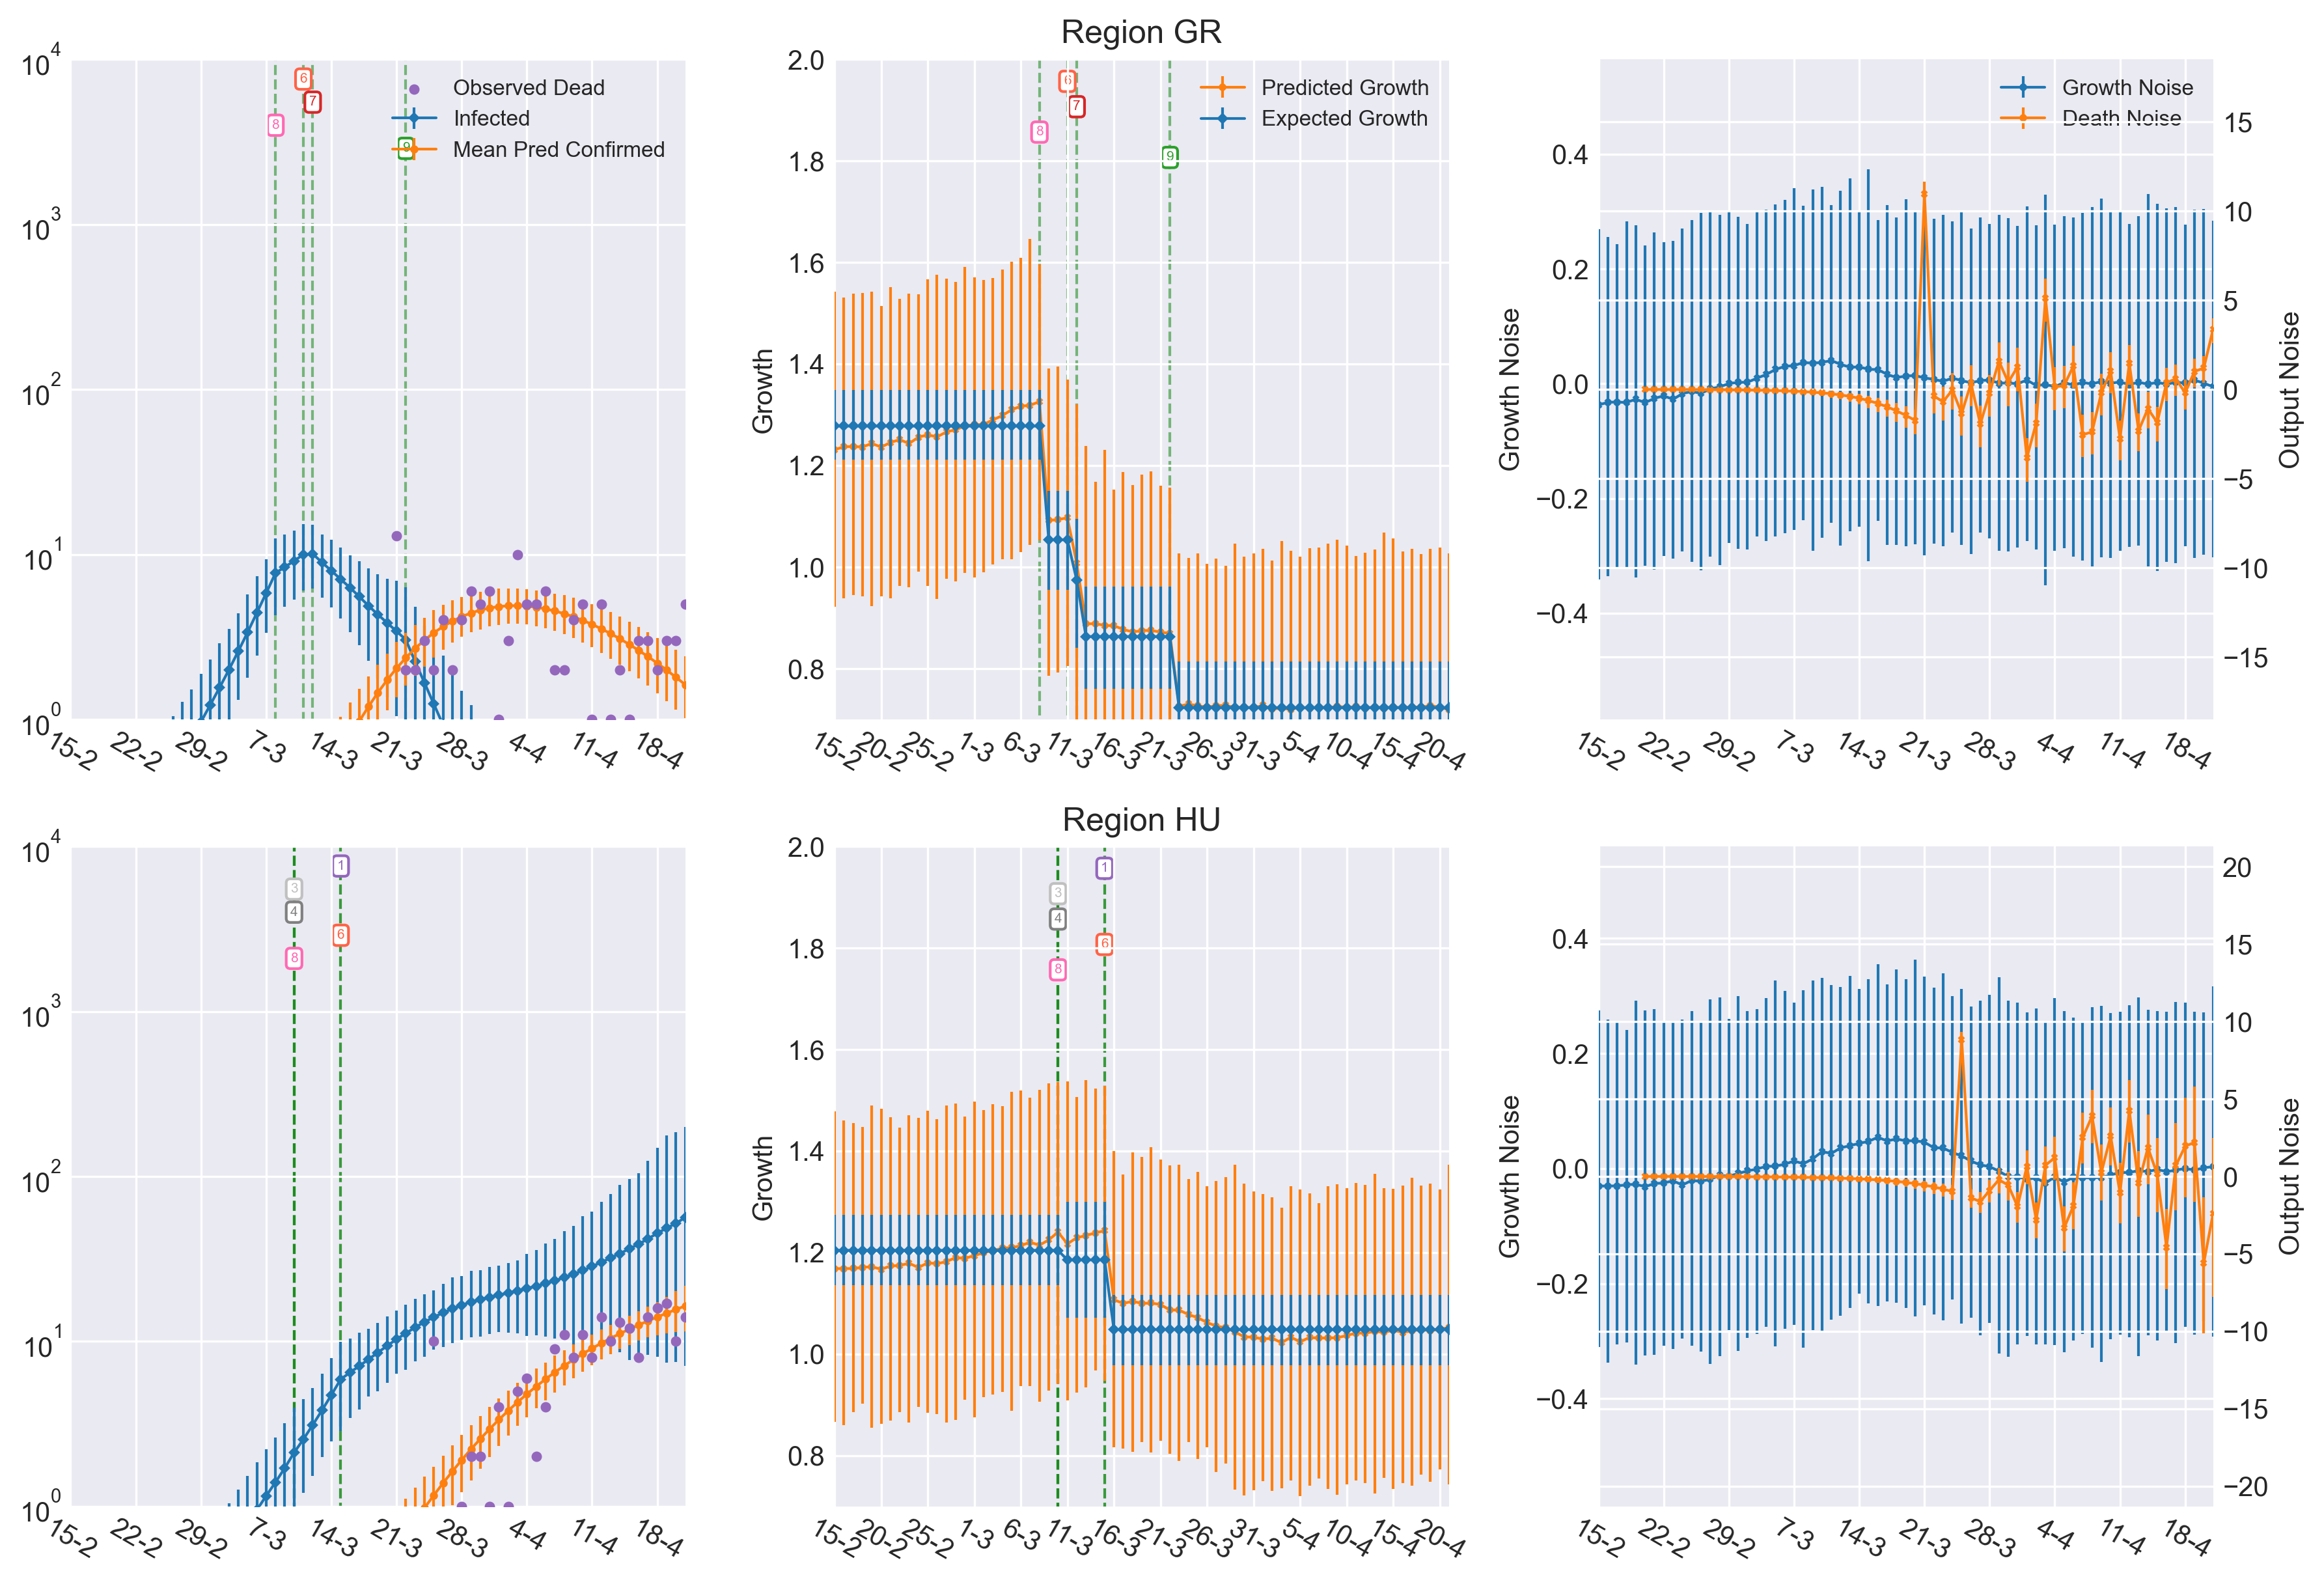

In [86]:
model.plot_region_predictions()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x138328a30>,
      dtype=object)

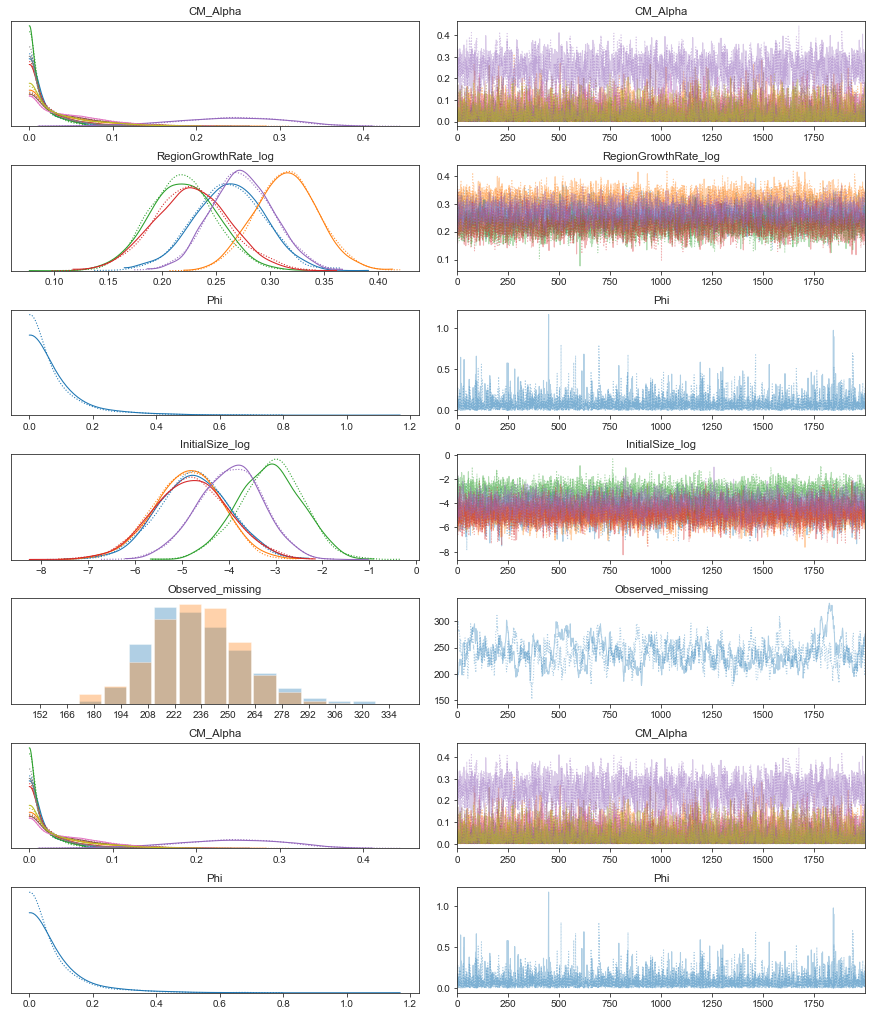

In [15]:
varnames = ['CM_Alpha',
 'RegionGrowthRate_log',
 'Phi',
 'InitialSize_log',
 'Observed_missing',
 'CM_Alpha',
 'Phi']
pm.traceplot(model.trace, varnames)

In [13]:
model.trace.varnames

['CM_Alpha_log__',
 'RegionGrowthRate_log',
 'Phi_log__',
 'Growth',
 'InitialSize_log',
 'Observed_missing',
 'CM_Alpha',
 'CMReduction',
 'Phi',
 'GrowthReduction',
 'ExpectedGrowth',
 'Z1',
 'Infected_log',
 'Infected',
 'ExpectedConfirmed',
 'ExpectedConfirmed_log',
 'Z2']

In [19]:
model.trace['Observed_missing'].shape

(4000, 1)

In [20]:
model.Observed.missing_values.tag.test_value

array([0])

/Users/jsalvatier/Library/Caches/pypoetry/virtualenvs/epimodel-Y5DpXmSQ-py3.8/lib/python3.8/site-packages/arviz/data/base.py:141: UserWarning: More chains (4000) than draws (5). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


KeyboardInterrupt: 

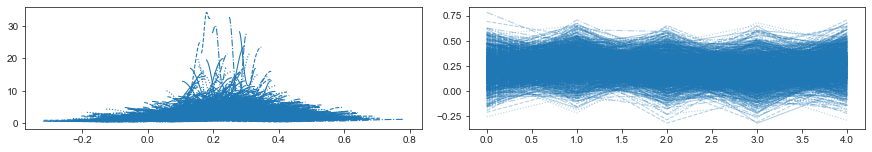

In [23]:
pm.traceplot(model.trace['Growth'])

In [36]:
pm.traceplot(model.trace['CM_Alpha_log__'][None,:,:])

TypeError: 'NoneType' object is not subscriptable

In [35]:
model.trace['CM_Alpha_log__'].shape

TypeError: 'NoneType' object is not subscriptable

In [38]:
np.linspace([0,1],[2,3], 10)

array([[0.        , 1.        ],
       [0.22222222, 1.22222222],
       [0.44444444, 1.44444444],
       [0.66666667, 1.66666667],
       [0.88888889, 1.88888889],
       [1.11111111, 2.11111111],
       [1.33333333, 2.33333333],
       [1.55555556, 2.55555556],
       [1.77777778, 2.77777778],
       [2.        , 3.        ]])

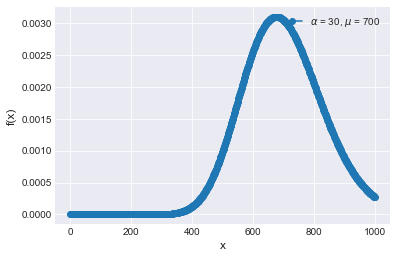

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy import special
plt.style.use('seaborn-darkgrid')

def NegBinom(a, m, x):
    pmf = special.binom(x + a - 1, x) * (a / (m + a))**a * (m / (m + a))**x
    return pmf

x = np.arange(0, 1000)
alphas = [30]
mus = [700]
for a, m in zip(alphas, mus):
    pmf = NegBinom(a, m, x)
    plt.plot(x, pmf, '-o', label=r'$\alpha$ = {}, $\mu$ = {}'.format(a, m))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

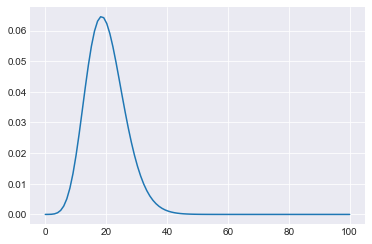

In [66]:
x = np.linspace(0, 100,100)
d = pm.NegativeBinomial.dist(mu=20, alpha=20+.1)
plt.plot(x, np.exp(d.logp(x).tag.test_value))